In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

# import os
# os.chdir('/content/drive/MyDrive/根據區域微氣候資料預測發電量競賽')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# 讀取 CSV 檔
add = pd.read_csv('ADD_FEATURE.csv')

# 對 Face 欄位進行 One-Hot 編碼
face_encoded_df = pd.get_dummies(add['Face'], drop_first=True, prefix='Face')

# 將新欄位與原始 DataFrame 合併並刪除舊欄位
add = pd.concat([add.drop('Face', axis=1), face_encoded_df], axis=1)
add.head()

,LocationCode,Latitude,Longitude,Height,Face_Northwest,Face_South,Face_Southeast,Face_Southwest,Face_West
0,1,23.8994,121.5444,5,False,True,False,False,False
1,2,23.8997,121.5447,5,False,True,False,False,False
2,3,23.8997,121.5450,5,False,True,False,False,False
3,4,23.8994,121.5444,5,False,True,False,False,False
4,5,23.8994,121.5447,5,False,False,False,True,False


In [4]:
# 讀取 CSV 檔
df = pd.read_csv('LALL_Train_Revise.csv')
df

,Serial,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,20240101063101,0.0,1016.54,17.50,86.79,55.17,0.00
1,20240101064101,0.0,1016.60,17.49,86.80,178.33,0.02
2,20240101065101,0.0,1016.66,17.50,86.95,343.25,0.05
3,20240101070101,0.0,1016.73,17.50,87.00,486.33,0.09
4,20240101071101,0.0,1016.78,17.58,86.94,683.92,0.15
...,...,...,...,...,...,...,...
137504,20240712144917,0.0,1004.01,36.53,64.84,11602.00,30.25
137505,20240712145917,0.0,1003.97,36.40,62.99,10885.08,26.46
137506,20240712150917,0.0,1004.07,36.08,65.69,13286.75,41.97
137507,20240712151917,0.0,1004.07,36.38,65.29,12502.58,36.51


In [5]:
# 割出日期、時間等資訊
df['year'] = df['Serial'].astype(str).str[:4].astype(int)   # 年份
df['month'] = df['Serial'].astype(str).str[4:6].astype(int)  # 月份
df['day'] = df['Serial'].astype(str).str[6:8].astype(int)   # 日期
df['hour'] = df['Serial'].astype(str).str[8:10].astype(int)  # 小時
df['minute'] = df['Serial'].astype(str).str[10:12].astype(int) # 分鐘
df['LocationCode'] = df['Serial'].astype(str).str[12:].astype(int) # 裝置代碼
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])    # 日期
df['weekday'] = df['date'].dt.weekday  # 星期幾 (0 表示星期一，6表示星期日）
df = df.drop(columns=['date'])

In [6]:
# 季節劃分函數
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

df['Season'] = df['month'].apply(get_season)

# 對 Season 欄位進行 One-Hot 編碼
df = pd.get_dummies(df, columns=['Season'], drop_first=False)

In [7]:
df = pd.merge(df, add, on='LocationCode', how='left')
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)
df

,Serial,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),year,month,day,...,Season_Summer,Season_Winter,Latitude,Longitude,Height,Face_Northwest,Face_South,Face_Southeast,Face_Southwest,Face_West
0,20240101063101,0.0,1016.54,17.50,86.79,55.17,0.00,2024,1,1,...,0,1,23.8994,121.5444,5,0,1,0,0,0
1,20240101064101,0.0,1016.60,17.49,86.80,178.33,0.02,2024,1,1,...,0,1,23.8994,121.5444,5,0,1,0,0,0
2,20240101065101,0.0,1016.66,17.50,86.95,343.25,0.05,2024,1,1,...,0,1,23.8994,121.5444,5,0,1,0,0,0
3,20240101070101,0.0,1016.73,17.50,87.00,486.33,0.09,2024,1,1,...,0,1,23.8994,121.5444,5,0,1,0,0,0
4,20240101071101,0.0,1016.78,17.58,86.94,683.92,0.15,2024,1,1,...,0,1,23.8994,121.5444,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137504,20240712144917,0.0,1004.01,36.53,64.84,11602.00,30.25,2024,7,12,...,1,0,23.9933,121.5985,3,1,0,0,0,0
137505,20240712145917,0.0,1003.97,36.40,62.99,10885.08,26.46,2024,7,12,...,1,0,23.9933,121.5985,3,1,0,0,0,0
137506,20240712150917,0.0,1004.07,36.08,65.69,13286.75,41.97,2024,7,12,...,1,0,23.9933,121.5985,3,1,0,0,0,0
137507,20240712151917,0.0,1004.07,36.38,65.29,12502.58,36.51,2024,7,12,...,1,0,23.9933,121.5985,3,1,0,0,0,0


# Heatmap

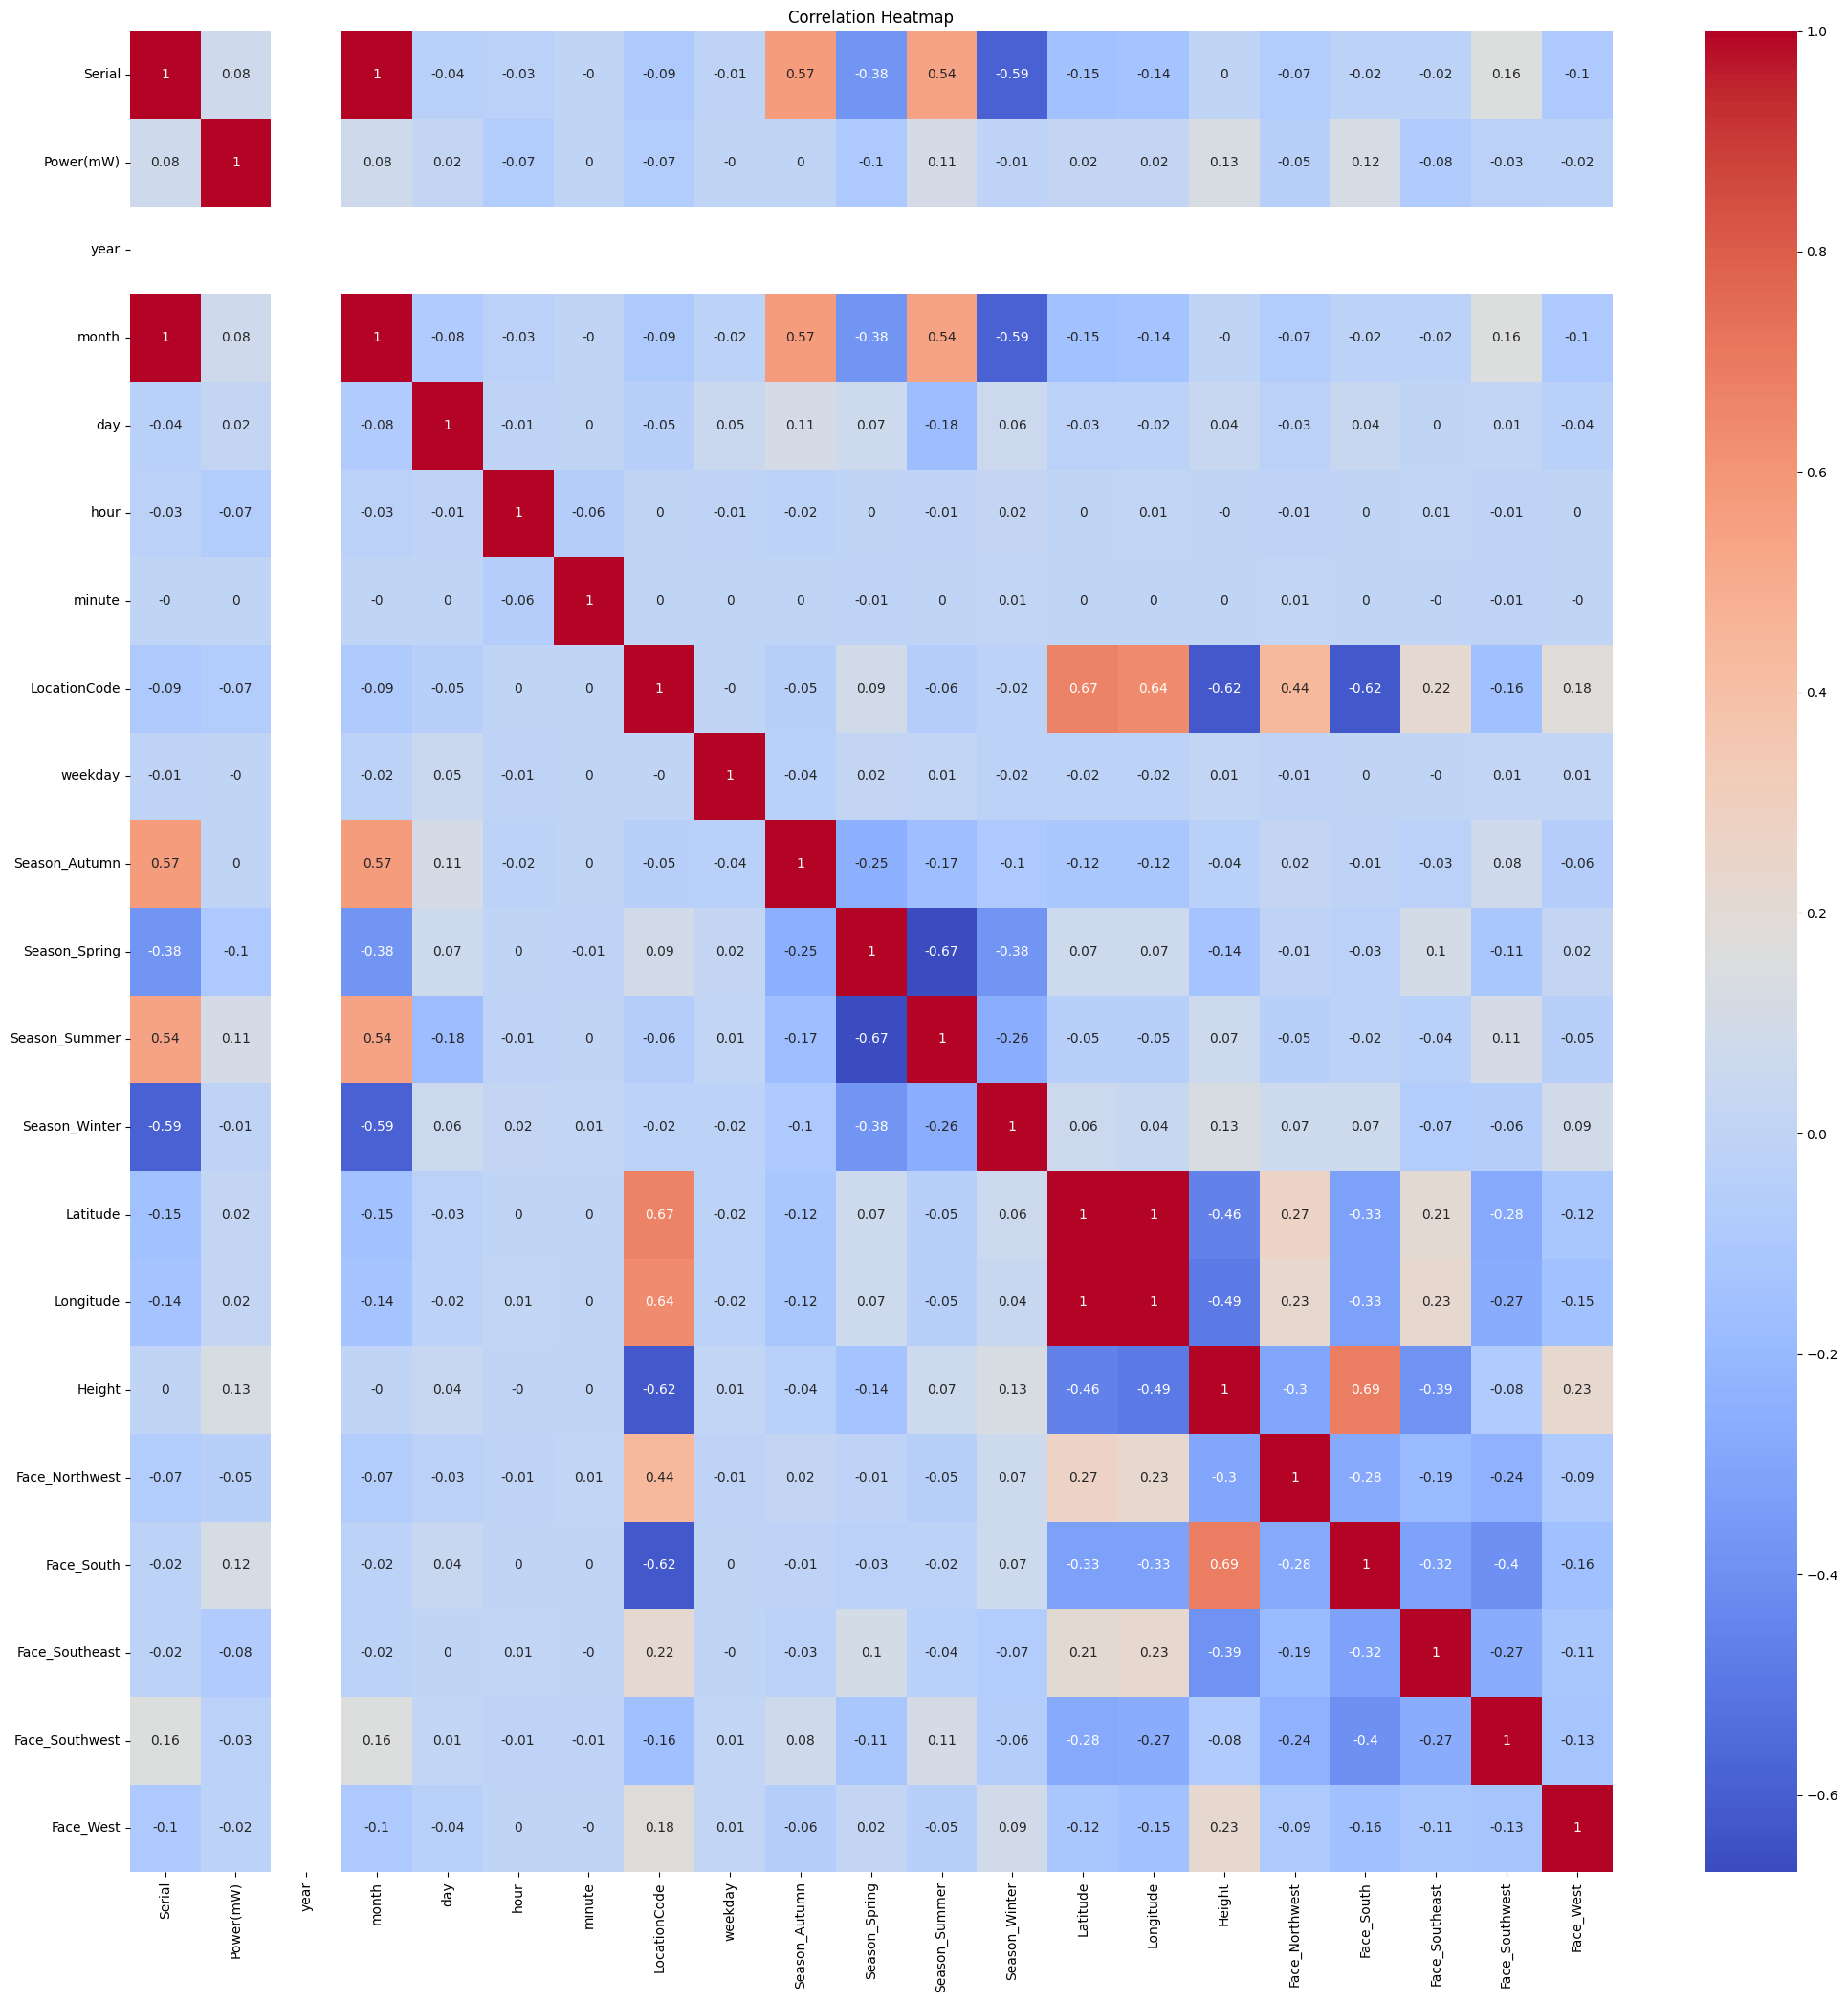

In [8]:
plt.figure(figsize=(25, 25))
df_test = df.copy()
df_test = df_test.drop(['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'], axis=1)
corr_matrix = df_test.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [9]:
correlation = df_test.corr().abs()
top_features = correlation['Power(mW)'].sort_values(ascending=False).head(20)
top_features

Power(mW)         1.000000
Height            0.127759
Face_South        0.124519
Season_Summer     0.106556
Season_Spring     0.096463
Serial            0.081603
Face_Southeast    0.080592
month             0.080394
hour              0.074588
LocationCode      0.069672
Face_Northwest    0.050768
Face_Southwest    0.027749
day               0.023754
Face_West         0.020616
Longitude         0.019494
Latitude          0.018544
Season_Winter     0.006830
Season_Autumn     0.004412
weekday           0.004029
minute            0.000089
Name: Power(mW), dtype: float64

In [10]:
# 進行訓練資料和測試資料的切割
from sklearn.model_selection import train_test_split

x = df[['Serial' ,'month', 'day', 'hour', 'minute', 'LocationCode' ,'weekday','Latitude' ,'Longitude','Height' ,
    'Face_South' ,'Face_Southeast' ,'Season_Winter' ,'Season_Summer' ,'Season_Spring']] # 使用Feature
y = df['Power(mW)'] # 使用Label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(103131, 15) (34378, 15) (103131,) (34378,)


In [11]:
x_train

,Serial,month,day,hour,minute,LocationCode,weekday,Latitude,Longitude,Height,Face_South,Face_Southeast,Season_Winter,Season_Summer,Season_Spring
16083,20240504124902,5,4,12,49,2,5,23.8997,121.5447,5,1,0,0,0,1
3529,20240301124501,3,1,12,45,1,4,23.8994,121.5444,5,1,0,0,0,1
56864,20240625091008,6,25,9,10,8,1,23.8997,121.5450,3,0,0,0,1,0
131635,20240303164317,3,3,16,43,17,6,23.9933,121.5985,3,0,0,0,0,1
137291,20240710070317,7,10,7,3,17,2,23.9933,121.5985,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,20240705184014,7,5,18,40,14,4,23.8978,121.5394,5,1,0,0,1,0
119879,20240308114316,3,8,11,43,16,4,24.0092,121.6172,1,0,0,0,0,1
103694,20240704091613,7,4,9,16,13,3,23.8978,121.5394,5,0,0,0,1,0
131932,20240308144917,3,8,14,49,17,4,23.9933,121.5985,3,0,0,0,0,1


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 對訓練集進行擬合並轉換
x_train_scaled = scaler.fit_transform(x_train)

# 對測試集進行轉換（使用已經在訓練集上擬合的標準化參數）
x_test_scaled = scaler.transform(x_test)

# 查看轉換後的數據形狀
print(x_train_scaled.shape, x_test_scaled.shape)

(103131, 15) (34378, 15)


In [13]:
# x_train_scaled

# Model Building and Evaluation

In [14]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

models = [
    # ('XGBoost', xgb.XGBRegressor(random_state=42)),
    # ('LightGBM', lgb.LGBMRegressor(random_state=42)),
    # ('RandomForest', RandomForestRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),
    # ('Lasso', Lasso(random_state=42)),
    # ('Ridge', Ridge(random_state=42)),
    # ('ElasticNet', ElasticNet(random_state=42))
]

# 殘差圖函數
def plot_residuals_side_by_side(model, X_train, y_train, X_test, y_test, model_name):
    # 預測訓練集和測試集
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    # 計算訓練和測試的殘差
    train_residuals = y_train - train_predictions
    test_residuals = y_test - test_predictions

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # 訓練集的殘差圖
    sns.residplot(x=train_predictions, y=train_residuals, lowess=True, color='blue', line_kws={'color': 'red', 'lw': 1}, ax=axes[0])
    axes[0].set_title(f'{model_name} Training Set Residuals')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    # 測試集的殘差圖
    sns.residplot(x=test_predictions, y=test_residuals, lowess=True, color='green', line_kws={'color': 'red', 'lw': 1}, ax=axes[1])
    axes[1].set_title(f'{model_name} Testing Set Residuals')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    plt.tight_layout()
    plt.show()

# 評估指標函數
def evaluate_model_with_residuals(model, X_train, y_train, X_test, y_test, model_name='Model'):
    # 訓練集的預測與評估
    train_predictions = model.predict(X_train)
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    # 測試集的預測與評估
    test_predictions = model.predict(X_test)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    print(f'{model_name} Training Set:')
    print(f'R2 Score: {train_r2:.4f}')
    print(f'Mean Squared Error: {train_mse:.4f}')
    print(f'Mean Absolute Error: {train_mae:.4f}\n')
    print(f'{model_name} Testing Set:')
    print(f'R2 Score: {test_r2:.4f}')
    print(f'Mean Squared Error: {test_mse:.4f}')
    print(f'Mean Absolute Error: {test_mae:.4f}\n')

for model_name, model in models:
    print(f'Fitting and evaluating {model_name}...')
    # 訓練模型
    model.fit(x_train_scaled, y_train)
    evaluate_model_with_residuals(model, x_train_scaled, y_train, x_test_scaled, y_test, model_name=model_name)
    # plot_residuals_side_by_side(model, x_train_scaled, y_train, x_test_scaled, y_test, model_name=model_name)
    print('=' * 40)

Fitting and evaluating CatBoost...
CatBoost Training Set:
R2 Score: 0.7791
Mean Squared Error: 47505.3597
Mean Absolute Error: 133.6014

CatBoost Testing Set:
R2 Score: 0.7705
Mean Squared Error: 49735.1698
Mean Absolute Error: 136.7725



In [15]:
# CatBoostRegressor(random_state=42, verbose=0)
# Fitting and evaluating CatBoost...
# CatBoost Training Set:
# R2 Score: 0.7791
# Mean Squared Error: 47505.3597
# Mean Absolute Error: 133.6014

# CatBoost Testing Set:
# R2 Score: 0.7705
# Mean Squared Error: 49735.1698
# Mean Absolute Error: 136.7725
# 7s

# Optuna-CatBoost

In [16]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
# import optuna

# # 定義目標函數
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 1000, 3000, step=500),
#         "depth": trial.suggest_int("depth", 6, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 3, 7),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.4, 0.8),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.8),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["Depthwise", "Lossguide"]),
#         "random_strength": trial.suggest_float("random_strength", 0.5, 1.0),
#     }

#     # 建立 CatBoost 模型
#     model = CatBoostRegressor(**params, random_state=42, verbose=0)
#     model.fit(x_train_scaled, y_train, eval_set=(x_test_scaled, y_test), early_stopping_rounds=200)

#     # 返回測試集上的 R2 分數作為目標
#     return model.score(x_test_scaled, y_test)

# # 開始超參數搜索
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

# # 輸出最佳結果
# best_params = study.best_params
# print("Best Params:", best_params)

In [17]:
# 個人微調後的最終結果
cat_model_tuned = CatBoostRegressor(
    iterations=3000,             # 增加迭代次數
    depth=10,                     # 增加模型深度
    learning_rate=0.048291852388211744,          # 更低的學習率
    l2_leaf_reg=4.265000761781573,               # 適度正則化
    bagging_temperature=0.7402703416136728,     # 平衡隨機性
    subsample=0.7896228883861611,               # 增加樣本比例
    grow_policy="Depthwise",     # 保持深度優化策略
    random_state=42,             # 確保結果可重現
    early_stopping_rounds=100,   # 加入早停
    random_strength=0.620821162440965,
    verbose=0                    # 關閉訓練日誌
)
cat_model_tuned.fit(
    x_train_scaled, y_train,
    eval_set=(x_test_scaled, y_test)
)
cat_model_tuned.fit(x_train_scaled, y_train)
evaluate_model_with_residuals(cat_model_tuned, x_train_scaled, y_train, x_test_scaled, y_test, model_name="CatBoost Regressor (Tuned)")

CatBoost Regressor (Tuned) Training Set:
R2 Score: 0.9912
Mean Squared Error: 1889.5790
Mean Absolute Error: 24.0447

CatBoost Regressor (Tuned) Testing Set:
R2 Score: 0.9174
Mean Squared Error: 17895.9794
Mean Absolute Error: 67.7265



In [ ]:
# CatBoost Regressor (Tuned) Training Set:
# R2 Score: 0.9912
# Mean Squared Error: 1889.5790
# Mean Absolute Error: 24.0447

# CatBoost Regressor (Tuned) Testing Set:
# R2 Score: 0.9174
# Mean Squared Error: 17895.9794
# Mean Absolute Error: 67.7265
# 29m 16s